<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/eda/car_train_test_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEFINE

In [109]:
# DEFINE
DATA_PATH                   = '/content/drive/My Drive/skill_factory_car_price_prediction_ml_dl'
RANDOM_SEED                 = 42

# IMPORT

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import re
from datetime import datetime

# Analyse
import pandas as pd
pd.set_option('max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split

In [112]:
train = pd.read_csv(DATA_PATH+'/train.csv')
test = pd.read_csv(DATA_PATH+'/test.csv')
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# FEATURES DESCRIBE

- **bodyType** - категориальный
- **brand** - категориальный
- **color** - категориальный
- **description** - текстовый
- **engineDisplacement** - числовой, представленный как текст
- **enginePower** - числовой, представленный как текст
- **fuelType** - категориальный
- **mileage** - числовой
- **modelDate** - числовой
- **model_info** - категориальный
- **name** - категориальный, желательно сократить размерность
- **numberOfDoors** - категориальный
- **price** - числовой, целевой
- **productionDate** - числовой
- **sell_id** - изображение (файл доступен по адресу, основанному на sell_id)
- **vehicleConfiguration** - не используется (комбинация других столбцов)
- **vehicleTransmission** - категориальный
- **Владельцы** - категориальный
- **Владение** - числовой, представленный как текст
- **ПТС** - категориальный
- **Привод** - категориальный
- **Руль** - категориальный

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [114]:
train.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


Построим *наивную* модель, чтобы понять в какую сторону двигаемся - к **улучшению** или к **ухудшению**.

Модель будет предсказывать среднюю цену авто по модели и году выпуска.


In [115]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [116]:
train_data, test_data = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [117]:
# Вместо iterrows() лучше всего использовать "Vectorization with Pandas series" и "Vectorization with NumPy arrays", так как
# они работают намного быстрее чем "iterrows()" и "apply()". В данном случае воспользуемся "iterrows()" так как датасет не такой большой.

predicts = []
for index, row in pd.DataFrame(test_data[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(train_data.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(test_data['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


По поводу итераций подробно расписано [здесь](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas)

# EDA AND PREPROCCESING

Для удобства переименнуем признаки

In [118]:
train.rename(columns={'bodyType': 'body',
                     'engineDisplacement': 'engine_displacement',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel',
                     'modelDate': 'model_date',
                     'numberOfDoors': 'num_of_doors',
                     'productionDate': 'production_date',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'transmission',
                     'Владельцы': 'owners',
                     'ПТС': 'vehicle_title',
                     'Владение': 'ownership',
                     'Привод': 'drive_type',
                     'Руль': 'wheel'}, inplace=True)

test.rename(columns={'bodyType': 'body',
                     'engineDisplacement': 'engine_displacement',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel',
                     'modelDate': 'model_date',
                     'numberOfDoors': 'num_of_doors',
                     'productionDate': 'production_date',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'transmission',
                     'Владельцы': 'owners',
                     'ПТС': 'vehicle_title',
                     'Владение': 'ownership',
                     'Привод': 'drive_type',
                     'Руль': 'wheel'}, inplace=True)

In [119]:
# Анализ признаков
def column_info(column): 

    if column.dtype == 'O':
        print(column.describe())
        print('-----------------------------')
        print(column.value_counts())

    else:
        print(column.describe())
        plt.figure(figsize=(11,6))
        column.plot(kind='hist', bins=20, edgecolor='black' ,linewidth=1.2)

In [120]:
train.duplicated().value_counts()

False    6682
dtype: int64

In [121]:
test.duplicated().value_counts()

False    1671
dtype: int64

## body

In [122]:
column_info(train.body)

count      6682
unique       17
top       седан
freq       2843
Name: body, dtype: object
-----------------------------
седан                   2843
внедорожник 5 дв.       2315
купе                     427
хэтчбек 5 дв.            296
лифтбек                  245
универсал 5 дв.          153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 44
хэтчбек 3 дв.             41
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          3
пикап двойная кабина       2
внедорожник открытый       2
седан 2 дв.                1
Name: body, dtype: int64


In [123]:
column_info(test.body)

count      1671
unique       14
top       седан
freq        698
Name: body, dtype: object
-----------------------------
седан                   698
внедорожник 5 дв.       581
купе                    116
хэтчбек 5 дв.            68
лифтбек                  54
универсал 5 дв.          43
минивэн                  32
родстер                  28
купе-хардтоп             20
хэтчбек 3 дв.            16
кабриолет                10
внедорожник 3 дв.         2
внедорожник открытый      2
пикап двойная кабина      1
Name: body, dtype: int64


## brand

In [124]:
column_info(train.brand)

count     6682
unique       3
top        BMW
freq      2805
Name: brand, dtype: object
-----------------------------
BMW         2805
MERCEDES    2294
AUDI        1583
Name: brand, dtype: int64


In [125]:
column_info(test.brand)

count     1671
unique       3
top        BMW
freq       730
Name: brand, dtype: object
-----------------------------
BMW         730
MERCEDES    552
AUDI        389
Name: brand, dtype: int64


## color

In [126]:
column_info(train.color)

count       6682
unique        16
top       чёрный
freq        2805
Name: color, dtype: object
-----------------------------
чёрный         2805
белый          1263
серый           733
синий           685
серебристый     341
коричневый      307
красный         203
бежевый          76
голубой          72
зелёный          70
фиолетовый       37
пурпурный        30
оранжевый        22
золотистый       21
жёлтый           16
розовый           1
Name: color, dtype: int64


In [127]:
column_info(test.color)

count       1671
unique        15
top       чёрный
freq         663
Name: color, dtype: object
-----------------------------
чёрный         663
белый          344
серый          192
синий          178
серебристый     79
коричневый      79
красный         63
голубой         19
зелёный         16
фиолетовый       9
бежевый          9
пурпурный        8
оранжевый        8
золотистый       3
жёлтый           1
Name: color, dtype: int64


## engine_displacement

In [128]:
column_info(train.engine_displacement)

count        6682
unique         48
top       2.0 LTR
freq         1929
Name: engine_displacement, dtype: object
-----------------------------
2.0 LTR          1929
3.0 LTR          1862
1.8 LTR           329
1.6 LTR           327
4.4 LTR           260
5.5 LTR           227
3.5 LTR           208
2.5 LTR           203
2.1 LTR           181
4.0 LTR           121
4.7 LTR           109
2.8 LTR            89
1.4 LTR            82
4.2 LTR            80
1.5 LTR            61
5.0 LTR            60
3.2 LTR            49
2.2 LTR            44
2.9 LTR            43
4.8 LTR            41
3.1 LTR            39
2.4 LTR            38
6.2 LTR            31
1.3 LTR            30
6.0 LTR            30
5.4 LTR            27
1.2 LTR            26
2.7 LTR            22
4.1 LTR            19
3.6 LTR            18
1.7 LTR            11
3.7 LTR            11
5.2 LTR            10
5.9 LTR            10
2.6 LTR             7
4.6 LTR             5
2.3 LTR             5
0.7 LTR             5
undefined LTR       5

In [129]:
column_info(test.engine_displacement)

count        1671
unique         43
top       2.0 LTR
freq          501
Name: engine_displacement, dtype: object
-----------------------------
2.0 LTR          501
3.0 LTR          487
1.6 LTR           83
1.8 LTR           82
4.4 LTR           69
2.5 LTR           45
3.5 LTR           42
5.5 LTR           41
2.1 LTR           40
4.0 LTR           32
4.7 LTR           28
1.4 LTR           24
4.2 LTR           23
2.8 LTR           17
4.8 LTR           16
2.2 LTR           14
5.0 LTR           14
1.5 LTR           12
3.2 LTR           11
2.3 LTR            9
6.2 LTR            9
2.9 LTR            7
1.2 LTR            7
6.0 LTR            7
2.4 LTR            6
5.4 LTR            6
3.1 LTR            5
3.6 LTR            5
1.7 LTR            4
4.1 LTR            4
5.2 LTR            3
3.7 LTR            3
1.3 LTR            2
5.8 LTR            2
2.7 LTR            2
2.6 LTR            2
undefined LTR      1
1.9 LTR            1
4.3 LTR            1
6.6 LTR            1
5.9 LTR          

In [130]:
train[train.engine_displacement=='undefined LTR']

,body,brand,color,description,engine_displacement,engine_power,fuel,mileage,model_date,model_info,name,num_of_doors,price,production_date,sell_id,vehicle_configuration,transmission,owners,ownership,vehicle_title,drive_type,wheel
2296,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,S Electro AT (136 кВт),5,2719000.0,2019,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
3725,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,Electro AT (126 кВт),5,2299711.0,2017,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый
3726,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,Electro AT (126 кВт),5,2170000.0,2017,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5862,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,Electro AT (126 кВт),5,1690000.0,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
6283,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,Electro AT (126 кВт),5,1790000.0,2015,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый


In [131]:
test[test.engine_displacement=='undefined LTR']

,body,brand,color,description,engine_displacement,engine_power,fuel,mileage,model_date,model_info,name,num_of_doors,production_date,sell_id,vehicle_configuration,transmission,owners,ownership,vehicle_title,drive_type,wheel
1005,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,Electro AT (126 кВт),5,2014,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый


По данным видно, что это электрокары. Гугл говорит, что у модели i3 объем двигателя составляет **0.6**.

## engine_power

In [132]:
column_info(train.engine_power)

count        6682
unique        146
top       184 N12
freq          602
Name: engine_power, dtype: object
-----------------------------
184 N12    602
249 N12    531
190 N12    343
306 N12    282
245 N12    274
211 N12    244
150 N12    218
170 N12    215
218 N12    189
156 N12    177
272 N12    163
136 N12    159
231 N12    144
204 N12    138
258 N12    131
333 N12    124
180 N12    115
177 N12    109
122 N12     81
585 N12     79
367 N12     78
224 N12     76
407 N12     74
388 N12     72
225 N12     71
160 N12     67
450 N12     62
192 N12     62
340 N12     62
235 N12     62
320 N12     58
313 N12     54
435 N12     50
163 N12     49
115 N12     48
455 N12     42
265 N12     40
381 N12     39
555 N12     39
290 N12     39
310 N12     39
300 N12     38
197 N12     35
575 N12     34
286 N12     32
350 N12     31
220 N12     28
612 N12     28
557 N12     26
571 N12     24
105 N12     24
255 N12     24
230 N12     23
238 N12     23
500 N12     23
140 N12     23
326 N12     22
250 N12  

In [133]:
column_info(test.engine_power)

count        1671
unique        120
top       184 N12
freq          157
Name: engine_power, dtype: object
-----------------------------
184 N12    157
249 N12    124
245 N12     81
190 N12     77
211 N12     66
306 N12     62
150 N12     60
170 N12     59
156 N12     46
218 N12     44
272 N12     43
136 N12     41
333 N12     36
204 N12     36
231 N12     35
180 N12     30
258 N12     29
367 N12     27
225 N12     22
177 N12     20
407 N12     19
455 N12     18
160 N12     16
224 N12     16
340 N12     16
585 N12     15
320 N12     15
235 N12     15
122 N12     14
163 N12     14
555 N12     14
286 N12     14
115 N12     14
435 N12     13
313 N12     12
239 N12     12
192 N12     12
197 N12     11
450 N12     11
557 N12     11
388 N12     10
575 N12      9
300 N12      9
125 N12      8
420 N12      8
194 N12      8
510 N12      8
250 N12      8
355 N12      8
143 N12      8
310 N12      7
326 N12      7
381 N12      7
354 N12      7
233 N12      6
265 N12      6
469 N12      6
372 N12  

## fuel

In [134]:
column_info(train.fuel)

count       6682
unique         4
top       бензин
freq        4804
Name: fuel, dtype: object
-----------------------------
бензин     4804
дизель     1861
гибрид       12
электро       5
Name: fuel, dtype: int64


In [135]:
column_info(test.fuel)

count       1671
unique         4
top       бензин
freq        1214
Name: fuel, dtype: object
-----------------------------
бензин     1214
дизель      454
гибрид        2
электро       1
Name: fuel, dtype: int64


## mileage

count      6682.000000
mean     120522.610895
std       81454.448294
min           1.000000
25%       59181.250000
50%      111000.000000
75%      168000.000000
max      999999.000000
Name: mileage, dtype: float64


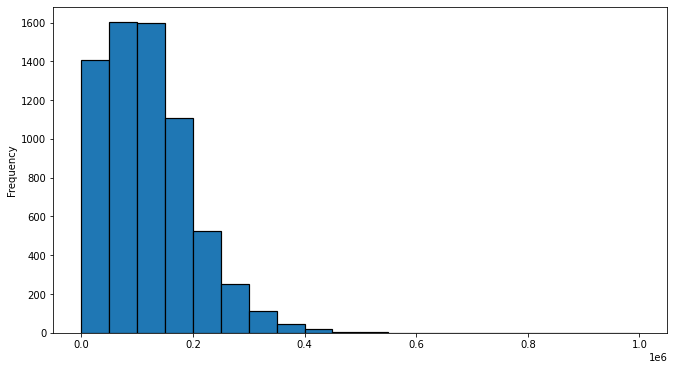

In [136]:
column_info(train.mileage)

count       1671.000000
mean      119724.664871
std        83467.240436
min            1.000000
25%        59373.000000
50%       109000.000000
75%       165375.500000
max      1000000.000000
Name: mileage, dtype: float64


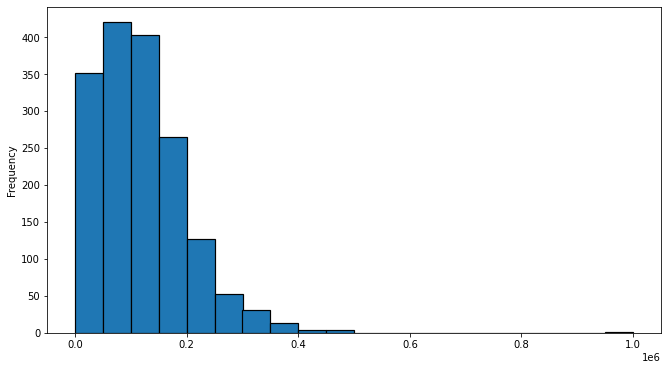

In [137]:
column_info(test.mileage)

## model_date

count    6682.000000
mean     2010.135588
std         5.370973
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: model_date, dtype: float64


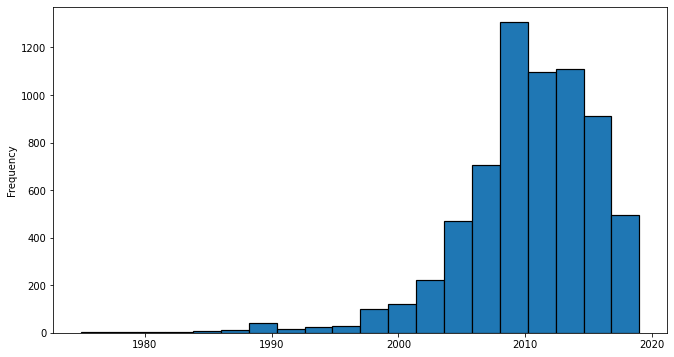

In [138]:
column_info(train.model_date)

count    1671.000000
mean     2009.975464
std         5.692836
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: model_date, dtype: float64


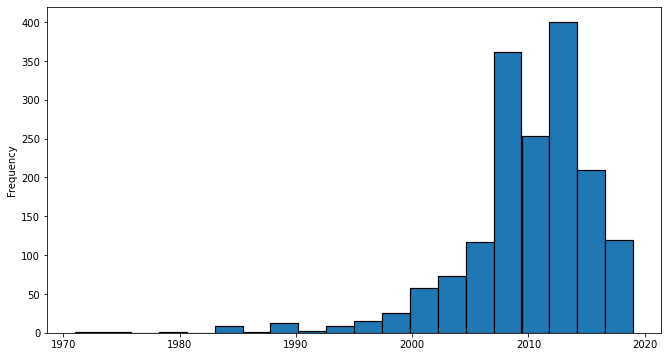

In [139]:
column_info(test.model_date)

## model_info

In [140]:
column_info(train.model_info)

count     6682
unique     118
top        5ER
freq       611
Name: model_info, dtype: object
-----------------------------
5ER                     611
3ER                     466
E_KLASSE                410
X5                      397
A6                      358
A4                      237
7ER                     229
C_KLASSE                222
X3                      216
X6                      215
S_KLASSE                214
Q7                      170
A5                      150
Q5                      148
1ER                     141
M_KLASSE                135
X1                      122
GL_KLASSE               115
A8                      106
A3                      105
G_KLASSE                 91
6ER                      76
CLS_KLASSE               74
A7                       70
GLK_KLASSE               69
Q3                       66
GLC_KLASSE               61
G_KLASSE_AMG             57
S_KLASSE_AMG             57
X4                       56
V_KLASSE                 55
A_KLASSE  

In [141]:
column_info(test.model_info)

count     1671
unique     101
top        5ER
freq       165
Name: model_info, dtype: object
-----------------------------
5ER                     165
3ER                     112
X5                      104
E_KLASSE                 80
A6                       75
S_KLASSE                 68
A4                       60
X6                       54
X3                       52
C_KLASSE                 52
Q5                       48
7ER                      47
1ER                      38
X1                       36
A5                       36
Q7                       35
M_KLASSE                 34
6ER                      31
A3                       27
GL_KLASSE                26
A8                       23
G_KLASSE                 22
Q3                       21
CLA_KLASSE               20
CLS_KLASSE               20
GLS_KLASSE               17
GLC_KLASSE               17
GLK_KLASSE               15
X4                       14
G_KLASSE_AMG             14
B_KLASSE                 12
X6_M      

## name

In [142]:
column_info(train.name)

count                      6682
unique                      900
top       200 2.0 AT (184 л.с.)
freq                        121
Name: name, dtype: object
-----------------------------
200 2.0 AT (184 л.с.)                                121
35i 3.0 AT (306 л.с.) 4WD                            116
2.0 AMT (211 л.с.) 4WD                               113
30d 3.0d AT (249 л.с.) 4WD                            87
400 3.0 AT (333 л.с.) 4WD                             76
520i 2.0 AT (184 л.с.)                                65
2.0 AMT (249 л.с.) 4WD                                65
350 d 3.0d AT (249 л.с.) 4WD                          64
320i xDrive 2.0 AT (184 л.с.) 4WD                     64
2.0 CVT (180 л.с.)                                    61
200 1.8 AT (184 л.с.)                                 61
1.8 CVT (160 л.с.)                                    60
350 3.5 AT (272 л.с.) 4WD                             56
200 2.0 AT (184 л.с.) 4WD                             49
520d 2.0d AT (190 

In [143]:
column_info(test.name)

count                          1671
unique                          536
top       35i 3.0 AT (306 л.с.) 4WD
freq                             35
Name: name, dtype: object
-----------------------------
35i 3.0 AT (306 л.с.) 4WD                        35
2.0 AMT (211 л.с.) 4WD                           32
30d 3.0d AT (249 л.с.) 4WD                       22
400 3.0 AT (333 л.с.) 4WD                        21
520i 2.0 AT (184 л.с.)                           21
2.0 CVT (180 л.с.)                               20
1.8 CVT (170 л.с.)                               18
320i 2.0 AT (184 л.с.)                           17
350 d 3.0d AT (249 л.с.) 4WD                     16
200 2.0 AT (184 л.с.)                            16
2.0 AMT (249 л.с.) 4WD                           15
1.8 CVT (160 л.с.)                               15
200 1.6 AMT (156 л.с.)                           15
200 1.8 AT (184 л.с.)                            15
520d 2.0d AT (190 л.с.)                          14
116i 1.6 AT (115 л.с

## num_of_doors

count    6682.000000
mean        4.268482
std         0.878687
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: num_of_doors, dtype: float64


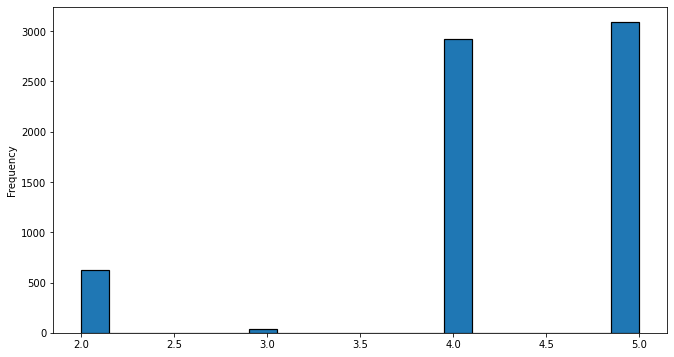

In [144]:
column_info(train.num_of_doors)

count    1671.000000
mean        4.236385
std         0.912202
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: num_of_doors, dtype: float64


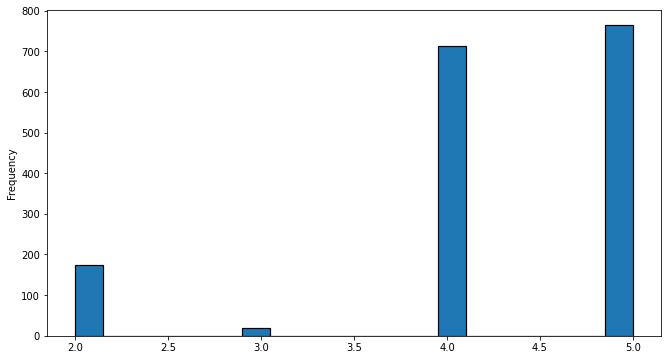

In [145]:
column_info(test.num_of_doors)

## production_date

count    6682.000000
mean     2012.031577
std         5.049676
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: production_date, dtype: float64


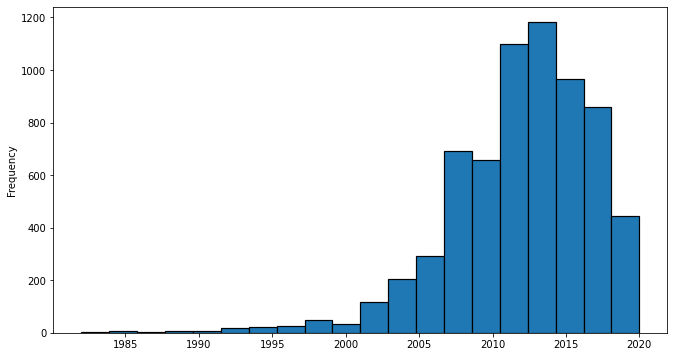

In [146]:
column_info(train.production_date)

count    1671.000000
mean     2011.927588
std         5.332324
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: production_date, dtype: float64


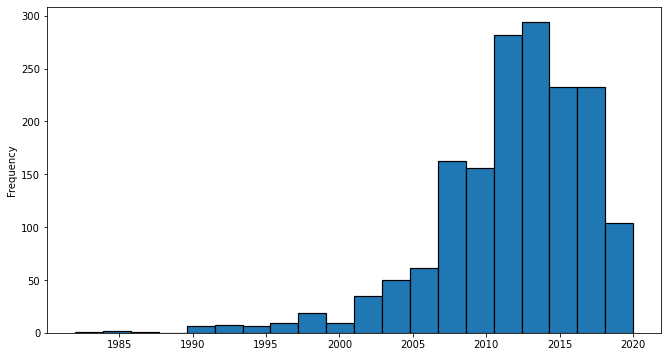

In [147]:
column_info(test.production_date)

## sell_id

Не содержит никакой полезной информации, удаляем.

## vehicle_configuration

In [148]:
column_info(train.vehicle_configuration)

count                              6682
unique                              288
top       ALLROAD_5_DOORS AUTOMATIC 3.0
freq                               1030
Name: vehicle_configuration, dtype: object
-----------------------------
ALLROAD_5_DOORS AUTOMATIC 3.0       1030
SEDAN AUTOMATIC 2.0                  746
SEDAN AUTOMATIC 3.0                  500
ALLROAD_5_DOORS AUTOMATIC 2.0        413
ALLROAD_5_DOORS ROBOT 2.0            176
ALLROAD_5_DOORS AUTOMATIC 4.4        129
SEDAN AUTOMATIC 2.5                  127
ALLROAD_5_DOORS AUTOMATIC 5.5        121
SEDAN AUTOMATIC 3.5                  104
SEDAN AUTOMATIC 1.6                  102
SEDAN VARIATOR 2.0                   100
SEDAN AUTOMATIC 1.8                   94
SEDAN AUTOMATIC 4.4                   93
SEDAN VARIATOR 1.8                    92
MINIVAN AUTOMATIC 2.1                 89
COUPE AUTOMATIC 2.0                   81
SEDAN ROBOT 2.0                       79
ALLROAD_5_DOORS AUTOMATIC 3.5         72
HATCHBACK_5_DOORS AUTOMATIC 1

In [149]:
column_info(test.vehicle_configuration)

count                              1671
unique                              205
top       ALLROAD_5_DOORS AUTOMATIC 3.0
freq                                262
Name: vehicle_configuration, dtype: object
-----------------------------
ALLROAD_5_DOORS AUTOMATIC 3.0       262
SEDAN AUTOMATIC 2.0                 195
SEDAN AUTOMATIC 3.0                 131
ALLROAD_5_DOORS AUTOMATIC 2.0       111
ALLROAD_5_DOORS ROBOT 2.0            50
ALLROAD_5_DOORS AUTOMATIC 4.4        39
SEDAN AUTOMATIC 1.6                  29
COUPE AUTOMATIC 3.0                  26
SEDAN AUTOMATIC 2.5                  25
SEDAN VARIATOR 1.8                   23
SEDAN VARIATOR 2.0                   23
SEDAN ROBOT 2.0                      22
SEDAN AUTOMATIC 1.8                  20
ALLROAD_5_DOORS AUTOMATIC 5.5        18
SEDAN AUTOMATIC 4.4                  18
SEDAN AUTOMATIC 4.7                  17
ALLROAD_5_DOORS AUTOMATIC 3.5        16
COUPE AUTOMATIC 2.0                  16
SEDAN AUTOMATIC 3.5                  16
ALLROAD

Данные из этого признака содержаться в других признаках. Можно удалить.

## transmission

In [150]:
column_info(train.transmission)

count               6682
unique                 4
top       автоматическая
freq                5261
Name: transmission, dtype: object
-----------------------------
автоматическая      5261
роботизированная     959
вариатор             325
механическая         137
Name: transmission, dtype: int64


In [151]:
column_info(test.transmission)

count               1671
unique                 4
top       автоматическая
freq                1299
Name: transmission, dtype: object
-----------------------------
автоматическая      1299
роботизированная     242
вариатор              81
механическая          49
Name: transmission, dtype: int64


## owners

In [152]:
column_info(train.owners)

count            6681
unique              3
top       3 или более
freq             2646
Name: owners, dtype: object
-----------------------------
3 или более    2646
1 владелец     2029
2 владельца    2006
Name: owners, dtype: int64


In [153]:
column_info(test.owners)

count            1671
unique              3
top       3 или более
freq              665
Name: owners, dtype: object
-----------------------------
3 или более    665
2 владельца    509
1 владелец     497
Name: owners, dtype: int64


In [154]:
train.owners.isnull().value_counts()

False    6681
True        1
Name: owners, dtype: int64

In [155]:
train[train.owners.isnull()==True]

,body,brand,color,description,engine_displacement,engine_power,fuel,mileage,model_date,model_info,name,num_of_doors,price,production_date,sell_id,vehicle_configuration,transmission,owners,ownership,vehicle_title,drive_type,wheel
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,4.2 AT (360 л.с.) 4WD,4,600000.0,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый


In [156]:
train.description[train.owners.isnull()==True]

4994    машина в идеале! вложено примерно 400тыс.руб \...
Name: description, dtype: object

In [157]:
train.description.iloc[4994]

'машина в идеале! вложено примерно 400тыс.руб \r\n замена ГРМ, всех расходников,\r\n двигатель контрактный с пробегом в 120,000км.\r\n рулевая рейка новая (не ремонтная а НОВАЯ!)\r\n новый кардан. \r\n новые гидро натяжители цепей 40тыс.руб. \r\n новый бензонасос, \r\n новая подвеска "бильштайн" \r\n и т.д. \r\n комплектация максимальная- черное дерево! штатный (снимаемый) фаркоп, предпусковой подогреватель WEBASTO, кованные диски (германия) R-20, телефон.\r\nНА ВТОРОМ ФОТО СТАРЫЙ РУЛЬ! СЕЙЧАС НОВЫЙ С ДЕРЕВОМ КАК НА ПОСЛЕДНИХ ФОТО... (старый отдам в довесок)\r\nнедавно сделана полная разводка глушителей, с установкой новых банок на обе трубы (на фото можно разглядеть снизу) банки от ренж ровер спорт, звук КЛАСС!!!\r\n много писать, звоните...\r\nфото 100% мои!\r\nвозможен обмен на битый или горевший  микроавтобус (фольксваген Т-5) мультиван свежих годов.\r\nСАЛОНЫ И ПРОЧИЕ "ПОМОЩНИКИ" ИДИТЕ ЛЕСОМ!!!!!!!!!\r\nфото 100% мои!\r\nпродажа НЕ срочная!!! с большим торгом не звонить.'

Машина старая. Но ПТС оригинал. По описанию кажеться, что владелец был один. Поставлю **1 владелец**.

In [158]:
train.owners.iloc[4994] = '1 владелец'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## ownership

In [159]:
column_info(train.ownership)

count                  2356
unique                  173
top       1 год и 8 месяцев
freq                     54
Name: ownership, dtype: object
-----------------------------
1 год и 8 месяцев      54
1 год и 2 месяца       53
1 год и 5 месяцев      46
1 год                  46
9 месяцев              46
2 года и 2 месяца      43
1 год и 11 месяцев     42
1 год и 10 месяцев     42
1 год и 4 месяца       40
1 год и 9 месяцев      39
1 год и 1 месяц        39
10 месяцев             39
3 года и 5 месяцев     37
2 года и 3 месяца      37
3 года                 36
3 года и 2 месяца      36
2 года и 4 месяца      36
8 месяцев              35
2 года и 7 месяцев     35
2 года                 34
2 года и 11 месяцев    32
11 месяцев             31
1 год и 7 месяцев      31
1 год и 3 месяца       30
1 год и 6 месяцев      28
3 года и 4 месяца      27
3 года и 7 месяцев     27
3 года и 1 месяц       26
2 года и 9 месяцев     26
2 года и 8 месяцев     26
2 года и 1 месяц       26
3 года и 10 месяцев  

In [160]:
column_info(test.ownership)

count                  579
unique                 131
top       1 год и 2 месяца
freq                    14
Name: ownership, dtype: object
-----------------------------
1 год и 2 месяца       14
8 месяцев              13
1 год и 8 месяцев      13
3 года                 13
2 года и 3 месяца      12
3 года и 8 месяцев     12
2 года                 12
2 года и 6 месяцев     11
7 месяцев              11
2 года и 4 месяца      11
3 года и 3 месяца      11
6 лет и 6 месяцев      11
1 год и 4 месяца       11
1 год и 3 месяца       10
1 год и 10 месяцев     10
3 года и 1 месяц       10
2 года и 8 месяцев     10
1 год                   9
2 года и 2 месяца       9
2 года и 11 месяцев     9
1 год и 11 месяцев      9
2 года и 10 месяцев     9
10 месяцев              9
1 год и 6 месяцев       8
3 года и 9 месяцев      7
11 месяцев              7
4 года и 5 месяцев      7
2 года и 9 месяцев      7
1 год и 9 месяцев       7
3 года и 5 месяцев      7
2 года и 7 месяцев      7
5 лет и 4 месяца        6

Слишком много пропусков, просто удалим признак.

## vehicle_title

In [161]:
column_info(train.vehicle_title)

count         6682
unique           2
top       Оригинал
freq          5970
Name: vehicle_title, dtype: object
-----------------------------
Оригинал    5970
Дубликат     712
Name: vehicle_title, dtype: int64


In [162]:
column_info(test.vehicle_title)

count         1671
unique           2
top       Оригинал
freq          1504
Name: vehicle_title, dtype: object
-----------------------------
Оригинал    1504
Дубликат     167
Name: vehicle_title, dtype: int64


## drive_type

In [163]:
column_info(train.drive_type)

count       6682
unique         3
top       полный
freq        4189
Name: drive_type, dtype: object
-----------------------------
полный      4189
задний      1790
передний     703
Name: drive_type, dtype: int64


In [164]:
column_info(test.drive_type)

count       1671
unique         3
top       полный
freq        1029
Name: drive_type, dtype: object
-----------------------------
полный      1029
задний       469
передний     173
Name: drive_type, dtype: int64


## wheel

In [165]:
column_info(train.wheel)

count      6682
unique        2
top       Левый
freq       6680
Name: wheel, dtype: object
-----------------------------
Левый     6680
Правый       2
Name: wheel, dtype: int64


In [166]:
column_info(test.wheel)

count      1671
unique        1
top       Левый
freq       1671
Name: wheel, dtype: object
-----------------------------
Левый    1671
Name: wheel, dtype: int64


Всего два праворульных авто, неинформативно, удаляем признак.

In [167]:
# Приведем данные в порядок с помощью общей функции
def data_prep(df):
    
    # body
    df.body = df.body.apply(lambda x: x.split()[0])
    
    # engine_displacement
    df.engine_displacement[df.engine_displacement=='undefined LTR'] = '0.6 LTR'
    df.engine_displacement = df.engine_displacement.apply(lambda x: x.split()[0])
    df.engine_displacement = df.engine_displacement.astype('float64')
    
    # engine_power
    df.engine_power = df.engine_power.apply(lambda x: x.split()[0])
    df.engine_power = df.engine_power.astype('float64')
    
    # name
    # BMW
    BMW = df[df.brand=='BMW']
    BMW.name = BMW.name.apply(lambda x: ' '.join(x.split()[0:2]) if len(x.split()[1])>4 else x.split()[0])
    
    # MERCEDES
    MERCEDES = df[df.brand=='MERCEDES']
    
    # Функция обработки имен MERCEDES.
    def merc_name(column):
    
        if len(column.split())>4:
            if column.split()[-1] == '4WD':
                return ' '.join(column.split()[:-5])

            elif column.split()[-1] != '4WD':
                return ' '.join(column.split()[:-4])
        else:
            return column.split()[0]
    
    MERCEDES.name = MERCEDES.name.apply(merc_name)
    
    # AUDI
    AUDI = df[df.brand=='AUDI']
    
    # Функция обработки имен AUDI.
    def audi_name(column):
    
        if len(column.split())>3:
            if column.split()[-1] == '4WD':
                return ' '.join(column.split()[:-4])

            elif column.split()[-1] != '4WD':
                return ' '.join(column.split()[:-3])
        else:
            return column.split()[0]
    
    AUDI.name = AUDI.name.apply(audi_name)
    
    # Объединения трех датафреймов в один.
    df = pd.concat([BMW, MERCEDES, AUDI])
    df.sort_index(axis=0, inplace=True)
    
    # Удаляем признаки
    df.drop(['vehicle_configuration', 'wheel', 'ownership', 'sell_id'], axis=1, inplace=True)
    
    return df

In [168]:
train = data_prep(train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [169]:
test = data_prep(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [170]:
def tax(data):
    
    if data<=100:
        return float(data*12)
    
    elif data>100 and data<=125:
        return float(data*25)
    
    elif data>125 and data<=150:
        return float(data*35)
    
    elif data>150 and data<=175:
        return float(data*45)
    
    elif data>175 and data<=200:
        return float(data*50)
    
    elif data>200 and data<=225:
        return float(data*65)
    
    elif data>225 and data<=250:
        return float(data*75)
        
    elif data>250:
        return float(data*150)
    
train['tax'] = train['engine_power'].apply(tax)
test['tax'] = test['engine_power'].apply(tax)

In [171]:
def days_in_use(row):
    
    # Отсчет дней будем вести от начала года даты производства, так как мы не знаем точной даты
    delta = datetime.now() - datetime(row,1,1)
    return delta.days

train['days_in_use'] = train['production_date'].apply(days_in_use)
test['days_in_use'] = test['production_date'].apply(days_in_use)

In [172]:
display(train.describe())
train.info()

,engine_displacement,engine_power,mileage,model_date,num_of_doors,price,production_date,tax,days_in_use
count,6682.000000,6682.000000,6682.000000,6682.000000,6682.000000,6.682000e+03,6682.000000,6682.000000,6682.000000
mean,2.782610,255.788686,120522.610895,2010.135588,4.268482,1.899868e+06,2012.031577,26630.120772,3215.102215
std,1.062753,109.240110,81454.448294,5.370973,0.878687,1.914153e+06,5.049676,23466.559177,1844.403483
min,0.600000,75.000000,1.000000,1975.000000,2.000000,3.013010e+05,1982.000000,900.000000,305.000000
25%,2.000000,184.000000,59181.250000,2007.000000,4.000000,8.000000e+05,2009.000000,9200.000000,1766.000000
50%,2.800000,231.000000,111000.000000,2011.000000,4.000000,1.300000e+06,2013.000000,17325.000000,2861.000000
75%,3.000000,306.000000,168000.000000,2014.000000,5.000000,2.299283e+06,2016.000000,45900.000000,4322.000000
max,6.600000,639.000000,999999.000000,2019.000000,5.000000,2.390000e+07,2020.000000,95850.000000,14184.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 0 to 6681
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body                 6682 non-null   object 
 1   brand                6682 non-null   object 
 2   color                6682 non-null   object 
 3   description          6682 non-null   object 
 4   engine_displacement  6682 non-null   float64
 5   engine_power         6682 non-null   float64
 6   fuel                 6682 non-null   object 
 7   mileage              6682 non-null   int64  
 8   model_date           6682 non-null   int64  
 9   model_info           6682 non-null   object 
 10  name                 6682 non-null   object 
 11  num_of_doors         6682 non-null   int64  
 12  price                6682 non-null   float64
 13  production_date      6682 non-null   int64  
 14  transmission         6682 non-null   object 
 15  owners               6682 non-null   o

In [173]:
display(test.describe())
test.info()

,engine_displacement,engine_power,mileage,model_date,num_of_doors,production_date,tax,days_in_use
count,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000
mean,2.758947,254.645721,119724.664871,2009.975464,4.236385,2011.927588,26257.585278,3253.081987
std,1.035046,107.474922,83467.240436,5.692836,0.912202,5.332324,23220.697907,1947.643147
min,0.600000,101.000000,1.000000,1971.000000,2.000000,1982.000000,2525.000000,305.000000
25%,2.000000,184.000000,59373.000000,2007.000000,4.000000,2009.000000,9200.000000,1766.000000
50%,2.700000,231.000000,109000.000000,2011.000000,4.000000,2013.000000,17325.000000,2861.000000
75%,3.000000,306.000000,165375.500000,2014.000000,5.000000,2016.000000,45900.000000,4322.000000
max,6.600000,700.000000,1000000.000000,2019.000000,5.000000,2020.000000,105000.000000,14184.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body                 1671 non-null   object 
 1   brand                1671 non-null   object 
 2   color                1671 non-null   object 
 3   description          1671 non-null   object 
 4   engine_displacement  1671 non-null   float64
 5   engine_power         1671 non-null   float64
 6   fuel                 1671 non-null   object 
 7   mileage              1671 non-null   int64  
 8   model_date           1671 non-null   int64  
 9   model_info           1671 non-null   object 
 10  name                 1671 non-null   object 
 11  num_of_doors         1671 non-null   int64  
 12  production_date      1671 non-null   int64  
 13  transmission         1671 non-null   object 
 14  owners               1671 non-null   object 
 15  vehicle_title        1671 non-null   o

# CORRELATION

Проведем корреляционный анализ **числовых** признаков.

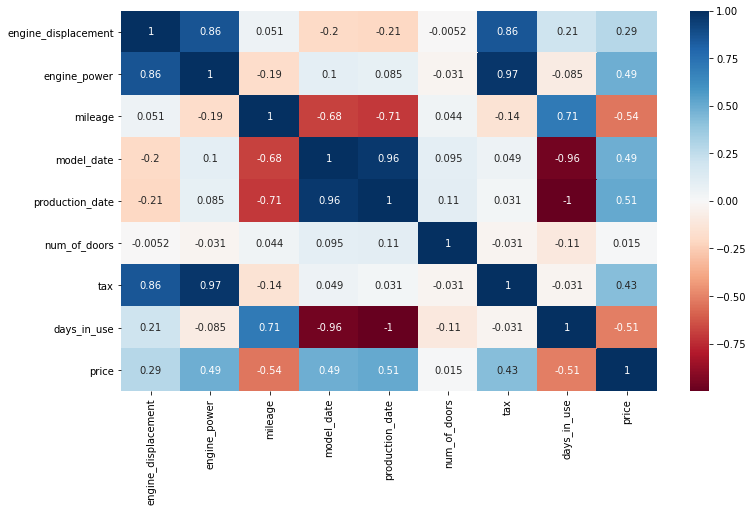

In [174]:
train_corr = pd.DataFrame()
train_corr = train[['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'num_of_doors', 'tax', 'days_in_use', 'price']]
plt.figure(figsize=(12,7))
sns.heatmap(train_corr.corr(), annot=True, cmap='RdBu')

Признаки между которыми наблюдается большая корреляция:

- **engine_power** и **engine_displacement**
- **mileage** и **days_in_use**
- **mileage** и **production_date**
- **mileage** и **model_date**
- **model_date** и **days_in_use**
- **model_date** и **production_date**
- **production_date** и **days_in_use**
- **engine_power** и **tax**
- **engine_displacement** и **tax**

Признаки которые больше всего коррелируют с таргетом, в порядке убывания (знак не учитывается):

- **mileage**
- **production_date** и **days_in_use**
- **model_date** и **engine_power**
- **tax**
- **engine_displacement**

Переведем часть признаков из разряда **числовых** в **категориальные**

In [175]:
train.model_date = train.model_date.astype(str)
test.model_date = test.model_date.astype(str)

train.production_date = train.production_date.astype(str)
test.production_date = test.production_date.astype(str)

train.num_of_doors = train.num_of_doors.astype(str)
test.num_of_doors = test.num_of_doors.astype(str)

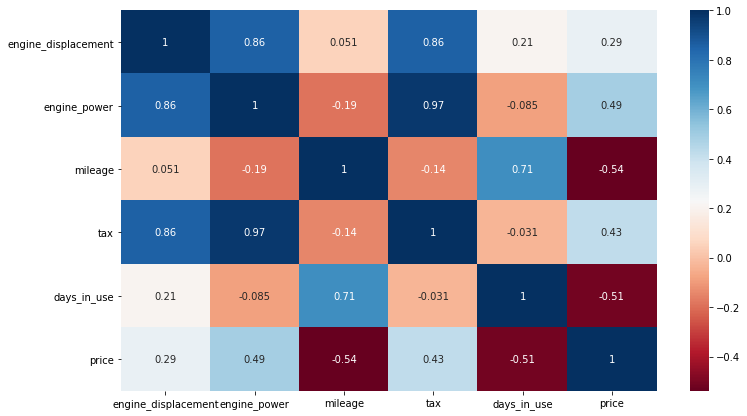

In [176]:
train_corr = train[['engine_displacement', 'engine_power', 'mileage', 'tax', 'days_in_use', 'price']]
plt.figure(figsize=(12,7))
sns.heatmap(train_corr.corr(), annot=True, cmap='RdBu')

Пока оставим так. При построении модели нужно будет поэксперементировать с признакми.

In [177]:
train.to_csv(r'/content/drive/My Drive/skill_factory_car_price_prediction_ml_dl/clear_train.csv', index=False ,header=True)
test.to_csv(r'/content/drive/My Drive/skill_factory_car_price_prediction_ml_dl/clear_test.csv',  index=False ,header=True)